In [1]:
from textblob import TextBlob
from textblob.blob import WordList
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import csv
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS
from matplotlib import pyplot as plt
from collections import Counter
import os
import json
import string
import gensim
from gensim import corpora
# nltk.download('wordnet')
%matplotlib inline

/home/kishore/.local/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
review_path = "/run/user/1000/gvfs/smb-share:server=hgspfilna09,share=marketplaceanalytics/Analytic Solutions Team/Glassdoor/"
json_files = [pos_json for pos_json in os.listdir(review_path) if pos_json.endswith('.json')]
reviews = pd.DataFrame()
for j in json_files:
    with open(review_path + j, 'r') as f:
        json_file = json.load(f)
        df = pd.DataFrame.from_dict(json_file).T
        reviews = pd.concat([reviews, df])
reviews.reset_index(inplace=True)
reviews.drop('index', axis=1, inplace=True)
reviews['Date'] = pd.to_datetime(reviews['Date'])
reviews.sort_values('Date', ascending=False, inplace=True)
reviews['Pros'] = reviews['Pros'].apply(str.lower)
reviews['Cons'] = reviews['Cons'].apply(str.lower)

In [3]:
sentences = reviews['Pros'].tolist()
sentences.extend(reviews['Cons'].tolist())

### Sentiment analysis of the reviews

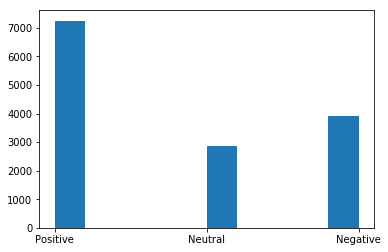

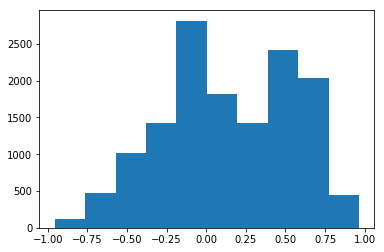

In [4]:
# Get the ensemble of textblob and nltk
sid = SentimentIntensityAnalyzer()
results = {'sentence': [],
           'polarity': [],
           'score': []}
for s in sentences:
    st = TextBlob(s)
    textblob_pol = st.sentiment.polarity
    nltk_pol = sid.polarity_scores(s)['compound']
    pol = np.average([textblob_pol, nltk_pol])
    if pol < -.1:
        sent  = 'Negative'
    elif pol > .1:
        sent = 'Positive'
    else:
        sent = 'Neutral'
    results['sentence'].append(s)
    results['polarity'].append(sent)
    results['score'].append(pol)
    
    
results = pd.DataFrame(results)
plt.hist(results['polarity'].tolist())
plt.show()
plt.hist(results['score'].tolist())
plt.show()

### Word cloud

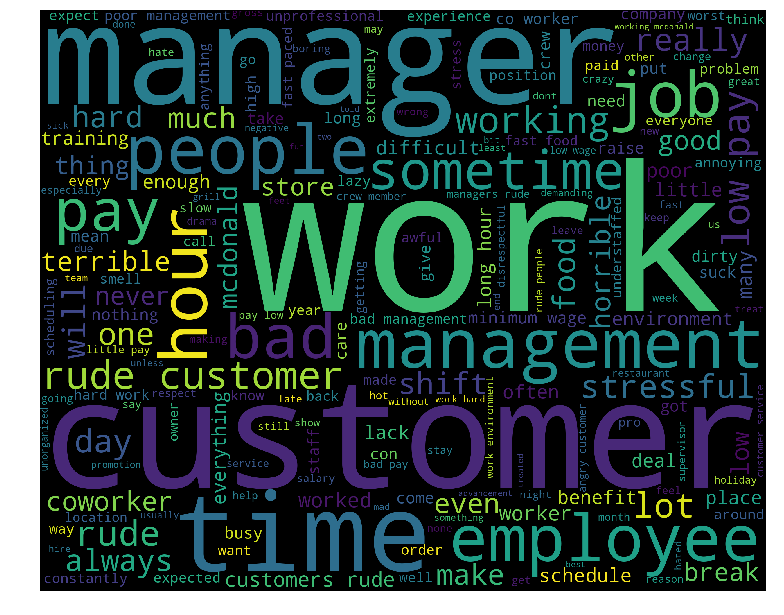

In [5]:
sentiment_analyzer = SentimentAnalyzer()
stopwords_set= set(stopwords.words("english"))
# generate wordcloud for all negative comments
neg_comments = results[results['polarity'] == 'Negative']['sentence'].tolist()
neg_comments = [x.split() for x in neg_comments]
neg_comments = sentiment_analyzer.all_words(neg_comments)

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=2500,
                      height=2000
                     ).generate(" ".join(neg_comments))
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Topic modeling

In [6]:
neg_comments = results[results['polarity'] == 'Negative']['sentence'].tolist()

stop = set(stopwords.words('english'))
stop.add('get')
stop.add('got')
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

neg_comments_clean = [clean(doc).split() for doc in neg_comments]

dictionary = corpora.Dictionary(neg_comments_clean)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in neg_comments_clean]

Lda = gensim.models.ldamodel.LdaModel

ldamodel = Lda(doc_term_matrix, num_topics=7, id2word = dictionary, passes=50)


In [7]:
ldamodel.print_topics()

[(0,
  '0.025*"working" + 0.022*"con" + 0.018*"time" + 0.016*"job" + 0.014*"pro" + 0.013*"fast" + 0.013*"hard" + 0.013*"stressful" + 0.011*"company" + 0.008*"sometimes"'),
 (1,
  '0.029*"employee" + 0.027*"work" + 0.011*"people" + 0.009*"time" + 0.009*"call" + 0.009*"customer" + 0.008*"management" + 0.008*"lot" + 0.007*"enough" + 0.007*"manager"'),
 (2,
  '0.073*"pay" + 0.048*"low" + 0.044*"work" + 0.022*"job" + 0.016*"bad" + 0.015*"wage" + 0.014*"hour" + 0.012*"people" + 0.012*"hard" + 0.010*"minimum"'),
 (3,
  '0.074*"management" + 0.065*"bad" + 0.031*"horrible" + 0.027*"manager" + 0.025*"poor" + 0.019*"pay" + 0.017*"customer" + 0.015*"employee" + 0.013*"crew" + 0.013*"terrible"'),
 (4,
  '0.104*"customer" + 0.095*"rude" + 0.023*"sometimes" + 0.020*"work" + 0.019*"people" + 0.018*"management" + 0.015*"manager" + 0.013*"deal" + 0.012*"worker" + 0.012*"coworkers"'),
 (5,
  '0.041*"hour" + 0.023*"manager" + 0.020*"time" + 0.020*"day" + 0.018*"shift" + 0.016*"one" + 0.016*"long" + 0.013*

### Top N negative words

In [8]:
all_neg_words = sentiment_analyzer.all_words([doc for doc in neg_comments_clean])
all_neg_words= Counter(all_neg_words)
c_df = {'word': [], 'count': []}
for k, v in all_neg_words.items():
    c_df['word'].append(k)
    c_df['count'].append(v)
c_df = pd.DataFrame(c_df)
c_df.sort_values('count', ascending=False, inplace=True)
c_df['rank'] = c_df['count'].rank(ascending=False)
c_df[c_df['count'] > 1].reset_index().drop('index', axis=1) \
                       .to_csv('top_n_negative_words.csv', index=False)

### Test

In [13]:
# Get all the reviews that have 'schedule' in the 'con' section
schedule_complaints = [r for r in reviews['Cons'].tolist() if 'schedule' in r]
schedule_complaints
pd.DataFrame(schedule_complaints, columns=['complaints']).to_excel('schedule_complaints.xlsx', index=False)